In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Make sure we run on Tensowflow 2:
print(tf.__version__)

2.4.0


# Read and prepare dataset
First, we start with defining helper functions to plot time series and reading data from csv:

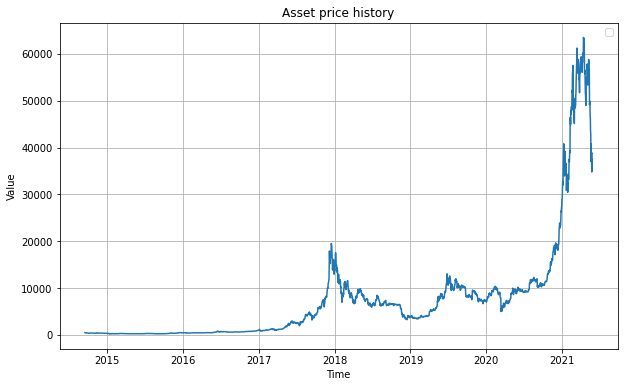

In [2]:
import csv
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None, title="Asset price history", legend=[]):
    plt.plot(time[start:end], series[start:end], format)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(legend)
    plt.grid(True)

def read_data(filepath='../data/BTC-USD.csv'):
    DATE_FORMAT = "%Y-%m-%d"
    time_step = []
    prices = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skip header
        for row in reader:
            if row[4] != 'null':
                time_step.append(datetime.strptime(row[0], DATE_FORMAT).date())
                prices.append(float(row[4]))
    return np.array(time_step), np.array(prices, dtype="float32")

time, series = read_data()

assert not np.any(np.isnan(series))
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


Now that we have the time series, let's split it into a training and validation set, so we can start forecasting:


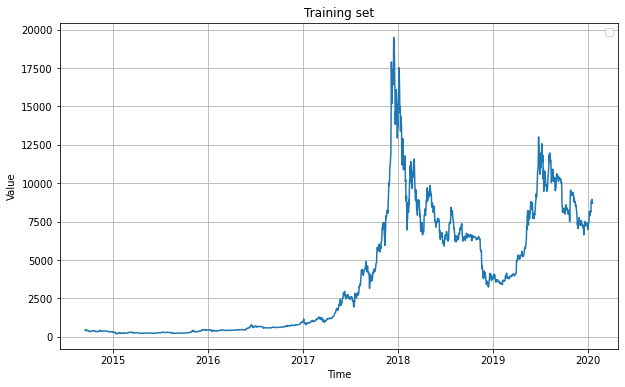

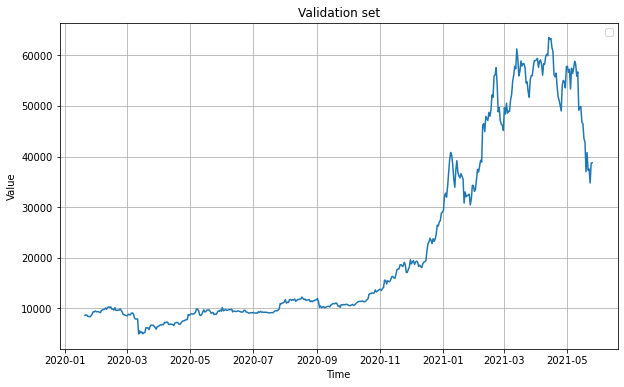

In [3]:
split_time = int(len(time) * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train, title="Training set")
plt.show()

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, title="Validation set")
plt.show()

# Prepare dataset for training
Having dataset loaded in, we have to split it into smaller windows suited for training.
Windows will be shuffled and grouped in batches for parallel training.

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Normalize the datasets:
max_train = np.max(np.abs(x_train), axis=0)
x_train /= max_train
max_valid = np.max(np.abs(x_valid), axis=0)
x_valid /= max_valid

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print("First dataset entry: " + str(list(dataset)[:1]))

First dataset entry: [(<tf.Tensor: shape=(32, 20), dtype=float32, numpy=
array([[0.01467832, 0.01509622, 0.01453266, 0.0148947 , 0.01409398,
        0.01362541, 0.01373496, 0.01158416, 0.00913471, 0.01076267,
        0.01067306, 0.01021982, 0.01078805, 0.01101998, 0.01083811,
        0.0116373 , 0.01197113, 0.0119441 , 0.0127118 , 0.01301291],
       [0.03342928, 0.03356099, 0.03359602, 0.03369639, 0.03359663,
        0.0320392 , 0.03109501, 0.02807887, 0.02904772, 0.0296598 ,
        0.02949332, 0.03014648, 0.03039841, 0.0303145 , 0.03014766,
        0.03036831, 0.03021531, 0.03013525, 0.03003416, 0.02925893],
       [0.01349267, 0.01326438, 0.0130998 , 0.01314719, 0.01338055,
        0.01394612, 0.01379825, 0.01365346, 0.01388826, 0.01380841,
        0.0146119 , 0.01503354, 0.01594402, 0.01497912, 0.01474371,
        0.01465985, 0.01426288, 0.01433381, 0.01409937, 0.01403336],
       [0.01232718, 0.01225148, 0.01235821, 0.01216111, 0.01216142,
        0.01216998, 0.01217639, 0.012160

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
61/61 - 0s - loss: 0.0134
Epoch 2/500
61/61 - 0s - loss: 0.0133
Epoch 3/500
61/61 - 0s - loss: 0.0132
Epoch 4/500
61/61 - 0s - loss: 0.0131
Epoch 5/500
61/61 - 0s - loss: 0.0130
Epoch 6/500
61/61 - 0s - loss: 0.0128
Epoch 7/500
61/61 - 0s - loss: 0.0127
Epoch 8/500
61/61 - 0s - loss: 0.0126
Epoch 9/500
61/61 - 0s - loss: 0.0125
Epoch 10/500
61/61 - 0s - loss: 0.0124
Epoch 11/500
61/61 - 0s - loss: 0.0123
Epoch 12/500
61/61 - 0s - loss: 0.0122
Epoch 13/500
61/61 - 0s - loss: 0.0121
Epoch 14/500
61/61 - 0s - loss: 0.0120
Epoch 15/500
61/61 - 0s - loss: 0.0119
Epoch 16/500
61/61 - 0s - loss: 0.0118
Epoch 17/500
61/61 - 0s - loss: 0.0117
Epoch 18/500
61/61 - 0s - loss: 0.0116
Epoch 19/500
61/61 - 0s - loss: 0.0115
Epoch 20/500
61/61 - 0s - loss: 0.0115
Epoch 21/500
61/61 - 0s - loss: 0.0114
Epoch 22/500
61/61 - 0s - loss: 0.0113
Epoch 23/500
61/61 - 0s - loss: 0.0112
Epoch 24/500
61/61 - 0s - loss: 0.0111
Epoch 25/500
61/61 - 0s - loss: 0.0110
Epoch 26/500
61/61 - 0s - loss: 0.

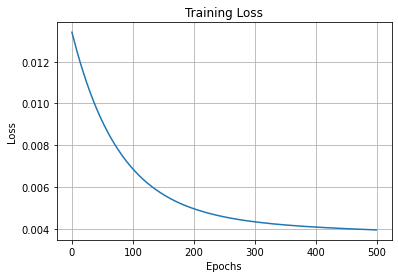

In [6]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=500,verbose=2)

plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

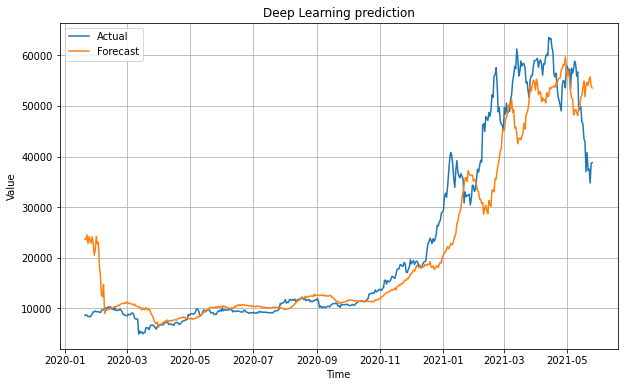

In [7]:
forecast = []
for time in range(len(series) - window_size):
    series_window = series[time:time + window_size]
    series_window_expanded = series_window[np.newaxis]
    predicted_value = model.predict(series_window_expanded)
    forecast.append(predicted_value)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# Get back the absolute results to plot the prices and calculate mean errors
results_abs = results * max_valid
x_valid_abs = x_valid * max_valid

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid_abs)
plot_series(time_valid, results_abs, title="Deep Learning prediction", legend=["Actual", "Forecast"])

In [8]:
print("MSE:")
print(tf.keras.metrics.mean_squared_error(x_valid_abs, results_abs).numpy())
print("MAE:")
print(tf.keras.metrics.mean_absolute_error(x_valid_abs, results_abs).numpy())

MSE:
39553440.0
MAE:
3905.1152
